##  Decision Tree Model for Binary classification

#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn import tree

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV

import graphviz
#!conda install --yes python-graphviz
#!conda install --yes graphviz

import matplotlib.pyplot as plt

#### Problem

    Is to identify products at risk of backorder before the event occurs so the business has time to react. 

#### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.
    
         Yes or 1 : Product backordered

         No or 0  : Product not backordered

#### Identify Right Error Metrics

    Based on the businees have to identify right error metrics.

#### Loading the data

In [2]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the No. row and columns

In [3]:
data.shape

(61589, 23)

Display the columns

In [4]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [5]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [6]:
data[:3]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe

In [7]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [8]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [9]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [10]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

#### Delete sku attribute

In [11]:
np.size(np.unique(data.sku, return_counts=True)[0])

61589

In [12]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [13]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [14]:
print (data.shape)

(61589, 22)


In [15]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data = data.dropna(axis=0)

In [16]:
print(data.isnull().sum())
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
(58186, 22)


In [17]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object') (58186, 22)


#### Converting Categorical to Numeric

    'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables

Creating dummy variables.

    If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [18]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [19]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, 
                      prefix=categorical_Attributes, prefix_sep="_", drop_first=True)

In [20]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [21]:
pd.value_counts(data['went_on_backorder_Yes'].values)

0    47217
1    10969
dtype: int64

#### Split the data in to train and test

sklearn.model_selection.train_test_split

    Split arrays or matrices into random train and test subsets

In [22]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [23]:
#To get the distribution in the target in train and test
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33067
1     7663
dtype: int64
0    14150
1     3306
dtype: int64


#### Decision Tree Model

In [24]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

In [25]:
np.argsort(clf.feature_importances_)

array([10, 18, 17, 16, 15, 14, 13, 12, 11, 19, 20,  7,  6,  4,  2,  1,  9,
        8,  3,  5,  0], dtype=int64)

In [26]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
pd.DataFrame([data.columns[indices],np.sort(importances)[::-1]])

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,national_inv,forecast_9_month,forecast_3_month,sales_6_month,sales_9_month,lead_time,in_transit_qty,forecast_6_month,sales_1_month,sales_3_month,...,stop_auto_buy_Yes,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,min_bank
1,0.625599,0.19154,0.136556,0.0463044,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
data.drop(columns=['went_on_backorder_Yes']).columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes'],
      dtype='object')

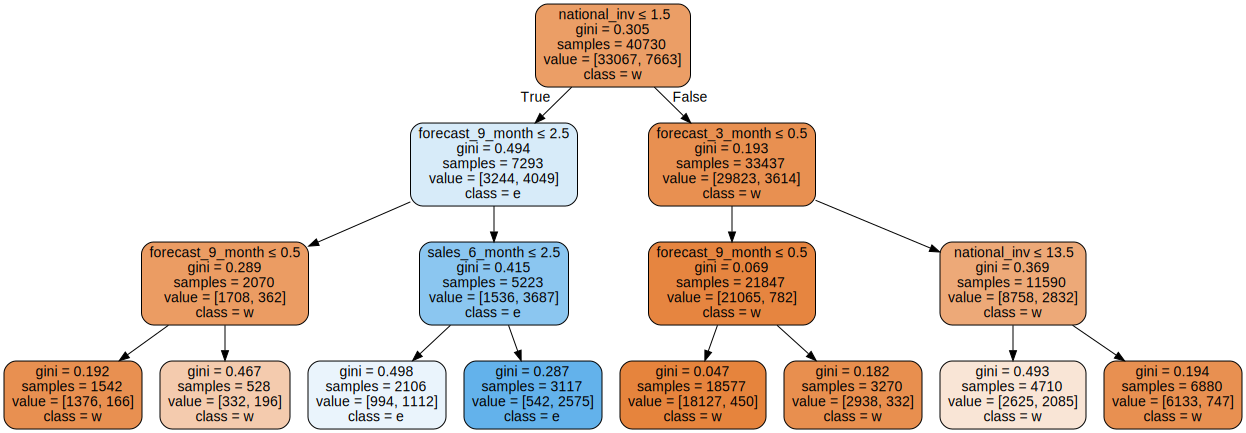

In [28]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=data.drop(columns=['went_on_backorder_Yes']).columns,
                                class_names='went_on_backorder_Yes', 
                                filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph

In [29]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [30]:
print(train_pred[:5])
print(test_pred[:5])

[0 0 1 0 0]
[0 0 0 0 0]


#### Getting evaluation metrics and evaluating model performance

In [31]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31531  1536]
 [ 3976  3687]]
[[13509   641]
 [ 1709  1597]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [32]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9535488553542807
Train TPR:  0.4811431554221584
Train Accuracy:  0.8646697765774614


In [33]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9546996466431096
Test TPR:  0.48306110102843314
Test Accuracy:  0.8653758020164987


#### Plotting ROC curve to modify the threshold if necessary

1. Initially we have predicted the classes. 
2. Now  the values of 0's and 1's itself are not sufficient to get the ROC curve. We need to have the probabilities.
3. We have a function called predict_proba that generates probalility for success which can be used for plotting ROC


In [34]:
train_pred_prob = clf.predict_proba(X_train)

In [35]:
print (train_pred_prob)

[[0.9757765  0.0242235 ]
 [0.55732484 0.44267516]
 [0.17388515 0.82611485]
 ...
 [0.55732484 0.44267516]
 [0.9757765  0.0242235 ]
 [0.8923476  0.1076524 ]]


predict_proba gives values for both success and failure. But we know that probability of failure= 1-probability of success. Thus it is sufficient for us to have only success probabilities. Hence we consider only success probabilities [:,1] is first column has success probabilities

In [36]:
train_pred_prob  = train_pred_prob[:,1]

#### Getting ROC curve to adjust the threshold 

In [37]:
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

#### Using matplotlib for plotting the ROC curve 

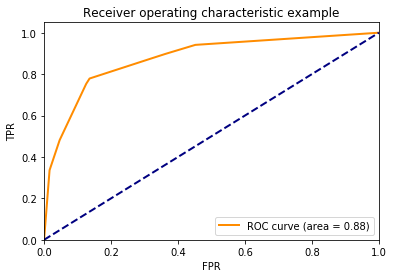

In [38]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [39]:
X = pd.DataFrame({'TPR':tpr,'TNR': 1-fpr, 'Threshold':thresholds})
pd.set_option('display.max_rows', 11000)
X

,TPR,TNR,Threshold
0,0.000000,1.000000,1.826115
1,0.336030,0.983609,0.826115
2,0.481143,0.953549,0.528015
3,0.753230,0.874165,0.442675
4,0.778807,0.864124,0.371212
5,0.876289,0.678652,0.108576
6,0.897951,0.637040,0.107652
7,0.941276,0.548190,0.101529
8,1.000000,0.000000,0.024224


#### Building Decision Tree Model using Variable Importance

In [40]:
indices

array([ 0,  5,  3,  8,  9,  1,  2,  4,  6,  7, 20, 19, 11, 12, 13, 14, 15,
       16, 17, 18, 10], dtype=int64)

In [41]:
select = indices[0:4]
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train[:,select], y_train)

In [42]:
train_pred = clf.predict(X_train[:,select])
test_pred = clf.predict(X_test[:,select])

In [43]:
print(train_pred[:5])
print(test_pred[:5])

[0 0 1 0 0]
[0 0 0 0 0]


#### Getting evaluation metrics and evaluating model performance

In [44]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31531  1536]
 [ 3976  3687]]
[[13509   641]
 [ 1709  1597]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [45]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9535488553542807
Train TPR:  0.4811431554221584
Train Accuracy:  0.8646697765774614


In [46]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9546996466431096
Test TPR:  0.48306110102843314
Test Accuracy:  0.8653758020164987


#### Grid Search for Hyper-parameter tuning

###### Parameters

* criterion : string, optional (default=”gini”)

    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
    
* min_samples_split : int, float, optional (default=2)

    The minimum number of samples required to split an internal node.
   
* max_depth : int or None, optional (default=None)

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
    
* min_samples_leaf : int, float, optional (default=1)

    The minimum number of samples required to be at a leaf node.
    
* max_leaf_nodes : int or None, optional (default=None)

    Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

In [47]:
# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

In [48]:
dt = tree.DecisionTreeClassifier()
clf = GridSearchCV(dt, param_grid, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 10, 20], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_leaf_nodes': [None, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [49]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [50]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

In [51]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31782  1285]
 [ 1624  6039]]
[[13373   777]
 [  933  2373]]


In [52]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9611395046420903
Train TPR:  0.7880725564400365
Train Accuracy:  0.9285784434078075


In [53]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9450883392226148
Test TPR:  0.7177858439201452
Test Accuracy:  0.9020394133822182


In [54]:
train_pred_prob = clf.predict_proba(X_train)
train_pred_prob  = train_pred_prob[:,1]
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

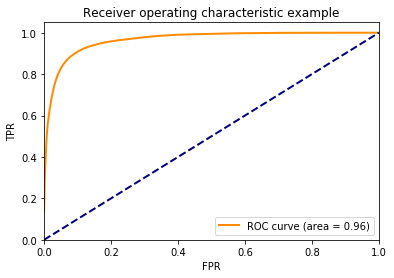

In [55]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [56]:
X = pd.DataFrame({'TPR':tpr,'TNR': 1-fpr, 'Threshold':thresholds})
pd.set_option('display.max_rows', 11000)
X

,TPR,TNR,Threshold
0,0.135848,1.000000,1.000000
1,0.248075,0.998669,0.951327
2,0.260081,0.998518,0.948454
3,0.264387,0.998458,0.942857
4,0.266475,0.998427,0.941176
5,0.273131,0.998306,0.927273
6,0.274697,0.998276,0.923077
7,0.284614,0.998065,0.915663
8,0.311758,0.997460,0.912281
9,0.321023,0.997248,0.910256
